# Image Classification with PyTorch

## Data loading


In [55]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data 

import torchvision
from torchvision import datasets, transforms

In [56]:
# torchvision contains convinience functions for popular datasets
ds_train = datasets.MNIST('data', train=True, download=True)

Each sample is a 28x28 image

(<PIL.Image.Image image mode=L size=28x28 at 0x198DFEF8780>, 5)


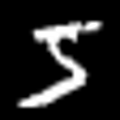

In [57]:
# if we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Let's transform the data to something that our Pytorch models will understand
for this purpose, we can supply a transform function to the datase

In [58]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

The image is now a `torch.Tensor`

In [59]:
type(ds_train[0][0])

torch.Tensor

The normalization is something you learned about in the lecture. Normalizing with $\mu=0, \sigma=1$ corresponds to no normalization. Let's compute the proper normalization constants!

In [60]:
# lets get only the images 
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [61]:
#########################################################################
# TODO: calculate the mean and std of MNIST images
# hint: to look for operations on pytorch tensor, refer to the official PyTorch docs 
# https://pytorch.org/docs/stable/
#########################################################################


mu =torch.mean(ims_train)
std = torch.std(ims_train)
mu,std

(tensor(0.1307), tensor(0.3081))

We normalize the data as below.

In [62]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu,std),
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)
print(ds_train[0][0].shape)

torch.Size([1, 28, 28])


In [11]:
print(ds_train[0][1])

5


Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class. Build a dataloader with a batch size of 64 and 4 workers (number of subprocess that peform the dataloading). Important: you need to shuffle the training data, not the test data.

**NOTE**: if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`

In [63]:
BATCH_SIZE = 16
NUM_WORKERS = 4
#########################################################################
# TODO: Build a dataloader for both train and test data.
#########################################################################

    
    
    
train_dataloader = torch.utils.data.DataLoader(
            ds_train,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS)

test_dataloader = torch.utils.data.DataLoader(
            ds_test,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS)


print(len(ds_train.data) //64 *64)
        

dl_train = train_dataloader
dl_test = test_dataloader

59968


## MLP in Pytorch

Ok, the dataloading works. Let's build our model, PyTorch makes this very easy. We will build replicate the model from our last exercises. However, now, we add another variable called `nLayer` that indicates how many linear layers that in your network. Please adapt your code from last exercise accordingly to allow different number of layers.

In [64]:
# These are the parameters to be used
nInput = 784
nOutput = 10
nLayer = 2
nHidden = 16
act_fn = nn.ReLU()

In [65]:
#########################################################################
# TODO: Implement the __init__ of the MLP class. 
# insert the activation after every linear layer. Important: the number of 
# hidden layers should be variable!
#########################################################################

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = [] 
        
        ##### implement this part #####
        layers.append(nn.Sequential(*[nn.Linear(nInput,nHidden),act_fn]))
        for i in range(nLayer-2):
            layers.append(nn.Sequential(*[nn.Linear(nHidden,nHidden),act_fn]))
        layers.append(nn.Sequential(*[nn.Linear(nHidden,nOutput)]))

        
        ###############################
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

In [15]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

In [16]:
mlp

MLP(
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=16, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=10, bias=True)
    )
  )
)

We already implemented the test function for you

In [66]:
def test(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Now you only need to implement the training and you are good to go

In [67]:
#########################################################################
# TODO: Implement the missing part of the training function. As a loss function we want to use cross entropy
# It can be called with F.cross_entropy().
# Hint: Pass through the model -> Backpropagate gradients -> Take gradient step
#########################################################################

def train(model, dl_train, optimizer, epoch, log_interval=100, device='cpu'):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        
        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()         
        
        ##### implement this part #####
        output=model(data)
        loss = F.cross_entropy(
            output, target
        )
        ###############################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))
        
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))

Ok, the setup is almost done. The onoly missing part is the optimizer. We are going to use Adam.

In [68]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())


In [20]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295517
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.536715
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.868526
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.579430
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.579954
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.635633
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.665823
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.793041
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.734552
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.604768
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.420528
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.277784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.221361
Train Epoch: 1 [20800/60000 (35%)]	Loss: 0.102229
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.290331
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.409204
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.391983
Train Epoch: 1 [27200/60000 (45%)]	Loss: 0.257939
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.159212
Train Epoch: 1 [30400/60000 (51%)]	Loss: 0.227660
Train Epoch: 1

Train Epoch: 5 [4800/60000 (8%)]	Loss: 0.267569
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.049695
Train Epoch: 5 [8000/60000 (13%)]	Loss: 0.179453
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.649060
Train Epoch: 5 [11200/60000 (19%)]	Loss: 0.025393
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.168183
Train Epoch: 5 [14400/60000 (24%)]	Loss: 0.320353
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.461091
Train Epoch: 5 [17600/60000 (29%)]	Loss: 0.270874
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.447881
Train Epoch: 5 [20800/60000 (35%)]	Loss: 0.300256
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.049283
Train Epoch: 5 [24000/60000 (40%)]	Loss: 0.005724
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.064714
Train Epoch: 5 [27200/60000 (45%)]	Loss: 0.098619
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.033701
Train Epoch: 5 [30400/60000 (51%)]	Loss: 0.364411
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.061753
Train Epoch: 5 [33600/60000 (56%)]	Loss: 0.033832
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.164811
Train

Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.061317
Train Epoch: 9 [11200/60000 (19%)]	Loss: 0.046490
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.080913
Train Epoch: 9 [14400/60000 (24%)]	Loss: 0.735750
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.053910
Train Epoch: 9 [17600/60000 (29%)]	Loss: 0.650012
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.003693
Train Epoch: 9 [20800/60000 (35%)]	Loss: 0.035162
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.049283
Train Epoch: 9 [24000/60000 (40%)]	Loss: 0.206800
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.284731
Train Epoch: 9 [27200/60000 (45%)]	Loss: 0.182686
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.305997
Train Epoch: 9 [30400/60000 (51%)]	Loss: 0.116212
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.034315
Train Epoch: 9 [33600/60000 (56%)]	Loss: 0.028327
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.057583
Train Epoch: 9 [36800/60000 (61%)]	Loss: 0.047577
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.529989
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.008900
T

After training, you should see test accuracies of > **94%** - By they way, here we report test accuracy, the last exercises reported test error. Accuracy is simply (1 - error). Both metrics are commonly reported, there is no clear preference in literature for one or the other.

Now, can you do some parameter tuning to boost the test accuracy to > **97%**?

In [69]:
#########################################################################
#TODO: modify the parameters below to see which setting that you can get to 97%
#########################################################################
nLayer = 4
nHidden =128
act_fn = nn.ReLU()

# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.281527
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.615826
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.241675
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.165483
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.918883
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.202891
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.074245
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.232649
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.392912
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.068562
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.158312
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.042387
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.081032
Train Epoch: 1 [20800/60000 (35%)]	Loss: 0.314340
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.458958
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.007648
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.286067
Train Epoch: 1 [27200/60000 (45%)]	Loss: 0.471470
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.105697
Train Epoch: 1 [30400/60000 (51%)]	Loss: 0.525106
Train Epoch: 1

Train Epoch: 5 [4800/60000 (8%)]	Loss: 0.016625
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.001028
Train Epoch: 5 [8000/60000 (13%)]	Loss: 0.004937
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.015158
Train Epoch: 5 [11200/60000 (19%)]	Loss: 0.001531
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.002074
Train Epoch: 5 [14400/60000 (24%)]	Loss: 0.002970
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.000245
Train Epoch: 5 [17600/60000 (29%)]	Loss: 0.003295
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.094197
Train Epoch: 5 [20800/60000 (35%)]	Loss: 0.225318
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.064536
Train Epoch: 5 [24000/60000 (40%)]	Loss: 0.004495
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.298253
Train Epoch: 5 [27200/60000 (45%)]	Loss: 0.001181
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.033662
Train Epoch: 5 [30400/60000 (51%)]	Loss: 0.000408
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.019245
Train Epoch: 5 [33600/60000 (56%)]	Loss: 0.089812
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.000841
Train

KeyboardInterrupt: 

Before you move on to the next exercise, you can further play with the other parameters (learning rate, epochs, a different optimizer, etc.) to get a feeling what can improve or hamper performance. 

## CNN
Alright, we matched our prior performance. Let's surpass it! You will soon see the power of CNN by building a small one yourself. The structure should be as follows

| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|

The layers you will need are: 

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.Flatten`

For layers without parameters you can alternatively use function in the forward pass:  

`F.max_pool2d, torch.flatten`

In [25]:
#########################################################################
# TODO: Implement the __init__ and forward method of the CNN class. 
# Hint: do not forget to flatten the appropriate dimension after the convolutional blocks. 
# A linear layers expect input of the size (B, H) with batch size B and feature size H
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        model=[]
        model.extend([nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),nn.ReLU()])
        model.extend([nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),nn.ReLU()])
        model.extend([nn.MaxPool2d(kernel_size=(2,2))])
        model.extend([nn.Dropout(0.25)])
        self.model=nn.Sequential(*model)
        linear=[]
        linear+=[nn.Linear(9216,128),nn.ReLU(),nn.Linear(128,10)]
        self.linear=nn.Sequential(*linear)
    def forward(self, x):
        x=self.model(x)
        x=x.view(x.shape[0],-1)
        x=self.linear(x)
        return x

In [26]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape

torch.Size([1, 10])

Alright, let's train!

In [27]:
optimizer = optim.Adam(cnn.parameters())

In [28]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293592
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.251392
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.174839
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.298850
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.465581
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.071741
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.020922
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.046413
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.048794
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.007504
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.121716
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.237033
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.189350
Train Epoch: 1 [20800/60000 (35%)]	Loss: 0.128862
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.067797
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.303096
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.203418
Train Epoch: 1 [27200/60000 (45%)]	Loss: 0.007296
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.095829
Train Epoch: 1 [30400/60000 (51%)]	Loss: 0.305966
Train Epoch: 1

KeyboardInterrupt: 

This will probably take a bit longer to train, as a convolutional network is not very efficient on a CPU. The current settings should get you around **99%** accuracy. Nice! 
Again, you should try different hyperparameters and see how far you can push the performance.

### Inline Question

If your model weight is randomly initalized, and no training is done as above. What accuracy do you think the model will get for a 10-class classification task in theory?

**Your answer**: 
10%.

## Training on CIFAR10

Now we are going to move to something more challenging - CIFAR10. We can reuse most of the code above. Thankfully, CIFAR is also a popular dataset, so we can again make use of a PyTorch convience function.

In [39]:
ds_train = datasets.CIFAR10(root='./data', train=True, download=True)
ds_test = datasets.CIFAR10(root='./data', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


This dataset is not normalized yet, so we need to calculate the normalization constants.

In [41]:
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.
ims_test = torch.tensor(ds_test.data)
ims_test = ims_test.float() / 255.


In [36]:
ims_train.std((0,1,2))
ims_train.shape

torch.Size([50000, 32, 32, 3])

In [35]:
#########################################################################
# TODO: calculate the mean and std of CIFAR
# hint: We want the mean and std of the channel dimension, these should
# be 3 dimensional
#########################################################################
mu = ims_train.mean((0,1,2))
std = ims_train.std((0,1,2))
mu,std

(tensor([0.3277, 0.3277, 0.3277]), tensor([0.2470, 0.2435, 0.2616]))

In [37]:
torch.mean(ims_train, dim=(0,1,2))

tensor([0.3277, 0.3277, 0.3277])

For CIFAR we want to make use of data augmentation to improve generalization. You will find all data augmentations data are included in torchvision here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [49]:
BATCH_SIZE = 16
NUM_WORKERS = 4 # if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`
#########################################################################
# TODO: Implement the proper transforms for the training and test dataloaders. 
# Then build train and test dataloaders with batch size 128 and 4 workers
#
# Train: 
# - Apply a random crop with size 32 on a padded version of the image with P=4
# - Flip the image horizontally with a probability of 40 %
# - Transform to a Tensor
# - Normalize with the constants calculated above
# Test: 
# - Transform to a Tensor
# - Normalize with the constants calculated above
#########################################################################
transform_train = transforms.Compose([
    transforms.RandomCrop((32,32),4),
    transforms.RandomHorizontalFlip(0.4),
    transforms.ToTensor(),
    transforms.Normalize(mu,std),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu,std),
])

ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

dl_train = torch.utils.data.DataLoader(
            ds_train,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS)

dl_test = torch.utils.data.DataLoader(
            ds_test,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


Setting up the  optimizer, this time we use SGD. The scheduler adapts the learning rate during traing (you can ignore it)

In [50]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        model=[]
        model.extend([nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0),nn.ReLU()])
        model.extend([nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),nn.ReLU()])
        model.extend([nn.MaxPool2d(kernel_size=(2,2))])
        model.extend([nn.Dropout(0.25)])
        self.model=nn.Sequential(*model)
        linear=[]
        linear+=[nn.Linear(12544,128),nn.ReLU(),nn.Linear(128,10)]
        self.linear=nn.Sequential(*linear)
    def forward(self, x):
        x=self.model(x)
        x=x.view(x.shape[0],-1)
        x=self.linear(x)
        return x
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [51]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.313746
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2.357586
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.342223
Train Epoch: 1 [4800/50000 (10%)]	Loss: 2.282389
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.286858


KeyboardInterrupt: 

This will not work. You should see the following error message

```
Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead
```

This error is telling us that something is not right in the definition of our model. Copy the CNN class from above and make changes, so the training works.

In [ ]:
#########################################################################
# TODO: Adapt the definition from the CNN class above to work on CIFAR.
# You can copy and run the following prompt for evaluation:
# CNN()(torch.randn(1,3,32,32)).shape
# It should print 'torch.Size([1, 10])'
# Hint: You need to change 2 things. 
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        model=[]
        model.extend([nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0),nn.ReLU()])
        model.extend([nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),nn.ReLU()])
        model.extend([nn.MaxPool2d(kernel_size=(2,2))])
        model.extend([nn.Dropout(0.25)])
        self.model=nn.Sequential(*model)
        linear=[]
        linear+=[nn.Linear(12544,128),nn.ReLU(),nn.Linear(128,10)]
        self.linear=nn.Sequential(*linear)
    def forward(self, x):
        x=self.model(x)
        x=x.view(x.shape[0],-1)
        x=self.linear(x)
        return x

Let's try again

In [52]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.280474
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2.327960
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.353579
Train Epoch: 1 [4800/50000 (10%)]	Loss: 2.277199
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.297877
Train Epoch: 1 [8000/50000 (16%)]	Loss: 2.339089
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.271260
Train Epoch: 1 [11200/50000 (22%)]	Loss: 2.246748
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.325574
Train Epoch: 1 [14400/50000 (29%)]	Loss: 2.344105
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.322162
Train Epoch: 1 [17600/50000 (35%)]	Loss: 2.352163
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.309003
Train Epoch: 1 [20800/50000 (42%)]	Loss: 2.303857
Train Epoch: 1 [22400/50000 (45%)]	Loss: 2.267087
Train Epoch: 1 [24000/50000 (48%)]	Loss: 2.352301
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.333178
Train Epoch: 1 [27200/50000 (54%)]	Loss: 2.288054
Train Epoch: 1 [28800/50000 (58%)]	Loss: 2.264236
Train Epoch: 1 [30400/50000 (61%)]	Loss: 2.342430
Train Epoch: 

KeyboardInterrupt: 

This should give 40 - 50 % - and if you are not already on Colab it will give you a stressed out laptop. The performance is a lot better than random, but we can definitely do better.

### Have fun with GPUs
You can already call it a day until this point because we won't grade the rest of the excecise. You can have more fun with the rest :)



If you didn't already, move to colab. To use a GPU, follow on the collaboratory menu tabs, "Runtime" => "Change runtime type" and set it to GPU. Then run the same training loop but now on GPU. 

It as easy as:

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

This should be way faster now. But the true advantage of the GPU is that we can use much bigger models now and still train them in a reasonable amount of time. PyTorch is again very handy. The torchvision library comes with varies state-of-the-art model architectures, some of which you have seen in the lecture.

In [ ]:
from torchvision.models import resnet18

In [ ]:
cnn = resnet18()
print(cnn)

Looks scary! But the only thing you need to change to make it work on CIFAR is the last layer.
Currently the last layer is:
```
  (fc): Linear(in_features=512, out_features=1000, bias=True)
```
out_features is the number of classes. This models are developed for Imagenet, a dataset with 1000 classes. So this part of the model you need to adapt. Additionally, you need to add a log-softmax layer again, as we us negative log-likelihood as the training criterion. 

In [ ]:
#########################################################################
# TODO: Adapt the Resnet to work on CIFAR
#########################################################################


In [ ]:
# This should print 'torch.Size([16, 10])'
cnn(torch.randn(16,3,32,32)).shape

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # this gives us additional speed up

optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 50
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

This should get us well above 75%, the best we got was ~ 80%.

Now, use different torchvision architectures, different optimizers (Adam is always a good choice), data augmentation techniques, and hyperparameter search to achieve a test accuracy of >90 %